# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [2]:
from sklearn.model_selection import train_test_split

_TARGET_COL = "salary_in_usd"
X = df[df.columns[(df.columns != _TARGET_COL) & (df.columns != "salary")]] # Зарплаты соответствуют целевой переменной
y = df[_TARGET_COL]
_X_train, _X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=239)
_X_val, _X_test, y_val, y_test = train_test_split(_X_test, y_test, test_size=0.5, random_state=239)
print(_X_train.shape, _X_val.shape, _X_test.shape)

(3004, 9) (375, 9) (376, 9)


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = X.select_dtypes(exclude="number").columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoder.fit(_X_train[categorical_features])
onehot_cols = encoder.get_feature_names_out()

numeric_features = X.columns[~X.columns.isin(categorical_features)]

scaler = StandardScaler()
scaler.fit(_X_train[numeric_features])

def prepare(df: pd.DataFrame):
    df[numeric_features] = scaler.transform(df[numeric_features])
    df = pd.concat([df, pd.DataFrame(encoder.transform(df[categorical_features]), index=df.index, columns=onehot_cols)], axis=1)
    return df.drop(columns=categorical_features)

X_train = prepare(_X_train)
X_val = prepare(_X_val)
X_test = prepare(_X_test)

# y_scaler = StandardScaler()
# y_train = pd.Series(y_scaler.fit_transform(pd.DataFrame(y_train))[:, 0])
# y_val = pd.Series(y_scaler.transform(pd.DataFrame(y_val))[:, 0])
# y_test = pd.Series(y_scaler.transform(pd.DataFrame(y_test))[:, 0])

In [4]:
_X_big_train = pd.concat([_X_train, _X_val])
X_big_train = pd.concat([X_train, X_val])
y_big_train = pd.concat([y_train, y_val])

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from time import time_ns

initial_model = LinearRegression()
initial_model.fit(X_big_train, y_big_train)

start = time_ns()
y_pred = initial_model.predict(X_test)
end = time_ns()
pred_time = end-start
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):_.0f}')
print(f'Скорость предсказания: {pred_time:_} нс на {len(y_test)} объектов ({pred_time/len(y_test):.0f} нс/объект)')

MAPE: 0.378
RMSE: 2_106_151_773
Скорость предсказания: 13_462_500 нс на 376 объектов (35805 нс/объект)


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [6]:
import itertools
import math
from sklearn.base import BaseEstimator
from time import time
from tqdm.contrib import itertools as tqdmit

def find_best_combo(
        Estimator: type[BaseEstimator], params: dict[str, list], tqdm: bool = True, 
        train_args: tuple[pd.DataFrame, pd.Series] | None = None, val: pd.DataFrame | None = None, **ekw
    ) -> tuple[tuple[float], float, float]:
    """
    Провести валидацию
    """
    best_combo: tuple[float] = None
    best_mse = None
    if train_args is None: train_args = X_train, y_train
    if val is None: val = X_val
    iterator = tqdmit.product(*params.values()) if tqdm else itertools.product(*params.values())
    start = time()
    for param_combo in iterator:
        val_model = Estimator(**dict(zip(params.keys(), param_combo)), **ekw)
        val_model.fit(*train_args)
        mse = mean_squared_error(y_val, val_model.predict(val))
        if best_mse is None or mse < best_mse:
            best_mse = mse
            best_combo = param_combo
    end = time()
    return best_combo, best_mse, end-start

def print_best_combo(params: dict[str, list], combo: tuple[float], mse: float):
    print("Лучший набор параметров:", *[f"- {k} = {v}" for k, v in zip(params, combo)], f"MSE: {mse:_.0f}", sep="\n")

C:\Users\boyko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth' : [1, 2, 3, 5],
    'learning_rate' : [0.1, 0.5, 1, 2],
    'n_estimators' : [20, 50, 100, 150],
    'gamma' : [0.0001, 0.001, 0.01, 0.1]
}
iterations = math.prod(map(len, params.values()))

best_xgbr_combo, best_mse, val_time = find_best_combo(XGBRegressor, params)

print_best_combo(params, best_xgbr_combo, best_mse)

100%|██████████| 256/256 [00:43<00:00,  5.85it/s]

Лучший набор параметров:
- max_depth = 1
- learning_rate = 1
- n_estimators = 100
- gamma = 0.0001
MSE: 2_398_984_960


In [8]:
from time import time_ns

def final_model(
        Estimator: type[BaseEstimator], params: dict[str, list], combo: tuple[float],
        train_args: tuple[pd.DataFrame, pd.Series] | None = None, test: pd.DataFrame | None = None, **ekw
    ):
    if train_args is None: train_args = X_big_train, y_big_train
    if test is None: test = X_test
    model = Estimator(**dict(zip(params, combo)), **ekw)
    model.fit(*train_args)
    start = time_ns()
    y_pred = model.predict(test)
    end = time_ns()
    return model, y_pred, end-start

In [9]:
xgbr_model, y_pred, pred_time = final_model(XGBRegressor, params, best_xgbr_combo)

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):_.0f}')
print(f'Скорость валидации: {val_time:_.2f} с на {iterations} итераций ({val_time/iterations:.2f} с/итер.)')
print(f'Скорость предсказания: {pred_time:_} нс на {len(y_test)} объектов ({pred_time/len(y_test):.0f} нс/объект)')

MAPE: 0.362
RMSE: 1_946_176_256
Скорость валидации: 43.73 с на 256 итераций (0.17 с/итер.)
Скорость предсказания: 17_025_400 нс на 376 объектов (45280 нс/объект)


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [10]:
from catboost import CatBoostRegressor

params = {
    'depth' : [1, 2, 3, 5],
    'learning_rate' : [0.05, 0.1, 0.2, 0.5],
    'iterations' : [100, 200, 300, 400],
}
iterations = math.prod(map(len, params.values()))

best_cbr_combo, best_mse, val_time = find_best_combo(CatBoostRegressor, params, verbose=False)

print_best_combo(params, best_cbr_combo, best_mse)

100%|██████████| 64/64 [00:24<00:00,  2.57it/s]

Лучший набор параметров:
- depth = 3
- learning_rate = 0.2
- iterations = 300
MSE: 2_359_564_549


In [11]:
cbr_model, y_pred, pred_time = final_model(CatBoostRegressor, params, best_cbr_combo, verbose=False)

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):_.0f}')
print(f'Скорость валидации: {val_time:_.2f} с на {iterations} итераций ({val_time/iterations:.2f} с/итер.)')
print(f'Скорость предсказания: {pred_time:_} нс на {len(y_test)} объектов ({pred_time/len(y_test):.0f} нс/объект)')

MAPE: 0.385
RMSE: 1_978_987_307
Скорость валидации: 24.91 с на 64 итераций (0.39 с/итер.)
Скорость предсказания: 2_492_500 нс на 376 объектов (6629 нс/объект)


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [12]:
from catboost import Pool

X_train_pool = Pool(_X_train, y_train, cat_features=categorical_features.to_list())
X_big_train_pool = Pool(_X_big_train, y_big_train, cat_features=categorical_features.to_list())

In [13]:
best_pool_cbr_combo, best_mse, val_time = find_best_combo(CatBoostRegressor, params, train_args=[X_train_pool], val=_X_val, verbose=False)

print_best_combo(params, best_pool_cbr_combo, best_mse)

100%|██████████| 64/64 [08:04<00:00,  7.57s/it]

Лучший набор параметров:
- depth = 2
- learning_rate = 0.2
- iterations = 100
MSE: 2_459_502_862


In [14]:
pool_cbr_model, y_pred, pred_time = final_model(
    CatBoostRegressor, params, best_cbr_combo,
    train_args=[X_big_train_pool], test=_X_test, verbose=False
)

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):_.0f}')
print(f'Скорость валидации: {val_time:_.2f} с на {iterations} итераций ({val_time/iterations:.2f} с/итер.)')
print(f'Скорость предсказания: {pred_time:_} нс на {len(y_test)} объектов ({pred_time/len(y_test):.0f} нс/объект)')

MAPE: 0.330
RMSE: 1_904_560_503
Скорость валидации: 484.31 с на 64 итераций (7.57 с/итер.)
Скорость предсказания: 6_191_700 нс на 376 объектов (16467 нс/объект)


**Ответ:**
> Качество улучшилось, но времени потребовалось в 13 раз больше...

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [17]:
from lightgbm import LGBMRegressor

params = {
    'max_depth' : [1, 2, 3, 5],
    'learning_rate' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators' : [100, 200, 300, 400],
}
iterations = math.prod(map(len, params.values()))

best_lgbmr_combo, best_mse, val_time = find_best_combo(LGBMRegressor, params, verbose=-1)

print_best_combo(params, best_lgbmr_combo, best_mse)

100%|██████████| 64/64 [00:04<00:00, 14.24it/s]

Лучший набор параметров:
- max_depth = 1
- learning_rate = 0.2
- n_estimators = 400
MSE: 2_508_843_377


In [16]:
lgbmr_model, y_pred, pred_time = final_model(LGBMRegressor, params, best_lgbmr_combo)

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):_.0f}')
print(f'Скорость валидации: {val_time:_.2f} с на {iterations} итераций ({val_time/iterations:.2f} с/итер.)')
print(f'Скорость предсказания: {pred_time:_} нс на {len(y_test)} объектов ({pred_time/len(y_test):.0f} нс/объект)')

MAPE: 0.339
RMSE: 1_980_672_216
Скорость валидации: 5.05 с на 64 итераций (0.08 с/итер.)
Скорость предсказания: 2_913_900 нс на 376 объектов (7750 нс/объект)


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:**
МОДЕЛЬ            | MAPE  | RMSE                | *v* обуч.<br>*(с/ит.)* | *v* предск.<br>*(мкс/об.)* | `depth` | `rate`  | `estimators`
:----------------:|-------|---------------------|------------------------|----------------------------|---------|---------|----------------
*Без бустинга*    | 0.378 | 2.11x10<sup>9</sup> | &mdash;                | 36                         | &mdash; | &mdash; | &mdash;
**XGBoost**       | 0.362 | 1.95x10<sup>9</sup> | 0.17                   | 45                         | 1       | 1       | 100
**CatBoost**      | 0.385 | 1.98x10<sup>9</sup> | 0.39                   | 7                          | 3       | 0.2     | 300
**CatBoost**+Pool | 0.33  | 1.9x10<sup>9</sup>  | 7.57                   | 16                         | 2       | 0.2     | 100
**LightGBM**      | 0.339 | 1.98x10<sup>9</sup> | 0.08                   | 8                          | 1       | 0.2     | 400

Все модели бустинга уменьшают RMSE на 5-10% по сравнению с простой линейной моделью. Самая низкая ошибка по обоим критериям достигается у **CatBoost** с использованием `Pool`, однако подбор гиперпараметров идёт очень медленно. **LightGBM** учится очень быстро и тоже достигает довольно низкой MAPE. У **XGBoost** чуть ниже RMSE, и он тоже обучается тоже довольно быстро, но он предсказывает дольше всех. Быстрее всех предсказывает **CatBoost** без `Pool`, но у него ужасное по сравнению с остальными MAPE. Вообще-то меня удивляет, насколько разительно отличаются **CatBoost** с и без `Pool`, вроде как они должны по сути делать одно и то же...

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import numpy as np
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
ratings = ratings.T
ratings.shape

(1001, 5000)

Выкиньте строку под названием `user`.

In [23]:
ratings.drop(index="user", inplace=True)
ratings.shape

(1000, 5000)

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [29]:
ratings.fillna(0, inplace=True)
ratings.sample(random_state=157)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
beirut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044803


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(5, random_state=42)
kmeans.fit(ratings)
kmeans_labels = pd.Series(kmeans.labels_, ratings.index)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [56]:
kmeans_label_counts = kmeans_labels.value_counts()
kmeans_label_counts

3    882
0    115
4      1
2      1
1      1
Name: count, dtype: int64

In [60]:
kmeans_labels[kmeans_labels.isin(kmeans_label_counts[kmeans_label_counts == 1].index)]

the beatles     4
niИ             2
日dir en grey    1
dtype: int32

**Ответ:**
> Кластеризация вышла не очень полезной, какие-то одинокие исполнители образовали свои кластеры, а 996 остальных попали в одну группу. Видимо, из-за большой размерности пространства все объекты получаются очень разными и поэтому оказываются далеко от центра кластера, если их больше одного

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [61]:
# В чате правду писали, The Beatles получается разве что если взять random_state=42

kmeans_labels[kmeans_labels.isin(kmeans_label_counts[kmeans_label_counts == 1].index)]

the beatles     4
niИ             2
日dir en grey    1
dtype: int32

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [69]:
listeners = (ratings != 0).sum(axis=1).sort_values(ascending=False)
display(listeners.head())
display(listeners.tail())

the beatles           1671
radiohead             1389
deathcab for cutie     931
coldplay               841
modest mouse           814
dtype: int64

curtis mayfield     47
townes van zandt    47
municipal waste     47
refused             47
yellowcard          47
dtype: int64

In [68]:
avg_rating = (ratings.sum(axis=1) / ratings.shape[1]).sort_values(ascending=False)
display(avg_rating.head())
display(avg_rating.tail())

the beatles           0.018369
radiohead             0.011851
deathcab for cutie    0.006543
niИ                   0.006470
coldplay              0.006030
dtype: float64

plus-44                              0.000215
finger eleven                        0.000212
jenny lewis with the watson twins    0.000211
jet                                  0.000199
the quitters                         0.000180
dtype: float64

**Ответ:**
> Ну Битлз самые популярные, поэтому они довольно сильно отличаются от остальных исполнителей. Хотя это всё ещё зависит от начального расположения центров, вон Радиохэд не попало в свой кластер, и Битлз при другом `random_state` не попадают

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [77]:
from sklearn.preprocessing import normalize

ratings_normal = pd.DataFrame(normalize(ratings), index=ratings.index, columns=ratings.columns)
ratings_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [79]:
kmeans_normal = KMeans(5, random_state=42)
kmeans_normal.fit(ratings_normal)
kmeans_normal_labels = pd.Series(kmeans_normal.labels_, index=ratings_normal.index)
kmeans_normal_label_counts = kmeans_normal_labels.value_counts()
kmeans_normal_label_counts

4    486
1    162
3    140
2    133
0     79
Name: count, dtype: int64

**Ответ**
> Ура ура, стало лучше

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [88]:
from scipy.spatial.distance import cosine

centroids = kmeans_normal.cluster_centers_
distances_to_centroids: pd.Series = ratings_normal.apply(lambda v: cosine(v, centroids[kmeans_normal_labels[v.name]]), axis=1)
central_bands = pd.DataFrame()
for val in range(5):
    central_bands[val] = distances_to_centroids[kmeans_normal_labels == val].sort_values()[:10].index
print(f"Ближайшие к центроидам исполнители в каждом классе:")
central_bands

Ближайшие к центроидам исполнители в каждом классе:


,0,1,2,3,4
0,nas,fall out boy,brand new,the beatles,radiohead
1,jay-z,the all-americian rejects,blink-182,the rolling stones,the arcade fire
2,kanye west,paramore,alkaline trio,dylan. bob,the shins
3,lupe the gorilla,kelly clarkson,against me!,who,sufjan stevens
4,a tribe called quest,john mayer,underoath,led zeppelin.,belle and sebastian
5,the roots featuring d'angelo,the fray,descendents,miles davis.,broken social scene
6,gangstarr,maroon5,new found glory,simon and garfunkel,the pixies
7,little brother,dashboard confesssional,less than jake,"young, neil",animal collective
8,lil' wayne,somethings corporate,thrice,pink fluid,modest mouse
9,murs and 9th wonder,coldplay,chiodos,velvet underground,spoon


**Ответ:**
- **0 &mdash; рэп и хип-хоп:** американские рэперы _Nas_, _Jay-Z_, _Канье Уэст_, _Лупе Фиаско_*, американские хип-хоп-исполнители и группы _A Tribe Called Quest_, _The Roots_, _Gang Starr_, _Little Brother_, _Lil' Wayne_, _Murs & 9th Wonder_.
- **1 &mdash; рок и поп 00-х:** американские рок-группы _Fall Out Boy_ (2001), _The All-American Rejects_ (1999), _Paramore_ (2004), _The Fray_ (2002), _Maroon 5_ (2001), _Dashboard Confessional_ (1998) , _Something Corporate_ (2000), британская рок-группа _Coldplay_ (1998), американские поп- и рок-исполнители _Келли Кларксон_ (2002), _Джон Мейер_ (1998).
- **2 &mdash; панк-рок и хардкор:** американские рок-группы _Brand New_, _Blink-182_, американские панк-группы _Alkaline Trio_, _Against Me!_, _Descendents_, _New Found Glory_, _Less Than Jake_, американские хардкор-группы _Underøath_, _Thrice_, _Chiodos_.
- **3 &mdash; рок 60-х:** британские рок-группы _The Beatles_ (1962), _The Rolling Stones_ (1962), _The Who_ (1964), _Led Zeppelin_ (1968), _Pink Floyd_ (1965), американские группы _Simon & Garfunkel_ (1956), _V.U._ (1964), американские и канадские исполнители _Боб Дилан_ (1959), _Майлз Дэвис_ (1944), _Нил Янг_ (1961)
- **4 &mdash; рок и поп 00-х:** британская рок-группа _Radiohead_ (1985), канадские рок-группы _Arcade Fire_ (2003), _Broken Social Scene_ (1999), американские рок- и инди-рок-группы _The Shins_ (1997), _The Pixies_ (1986), _Modest Mouse_ (1993), _Spoon_ (1993), американский инди-рок-исполнитель _Суфьян Стивенс_ (1999), шотландская инди-поп-группа _Belle and Sebastian_ (1996), американская поп-группа _Animal Collective_ (1999)

Моя лень, незнание темы и приближение дедлайна домашки не позволяют мне углубиться в особенности исполнителей 1 и 4 кластера. Мне не удалось понять, чем они отличаются

*Исполнитель именно _Лупе Фиаско_. _Lupe The Gorilla_ — это его песня    
**Количество опечаток в названиях исполнителей в данных просто поразительное

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

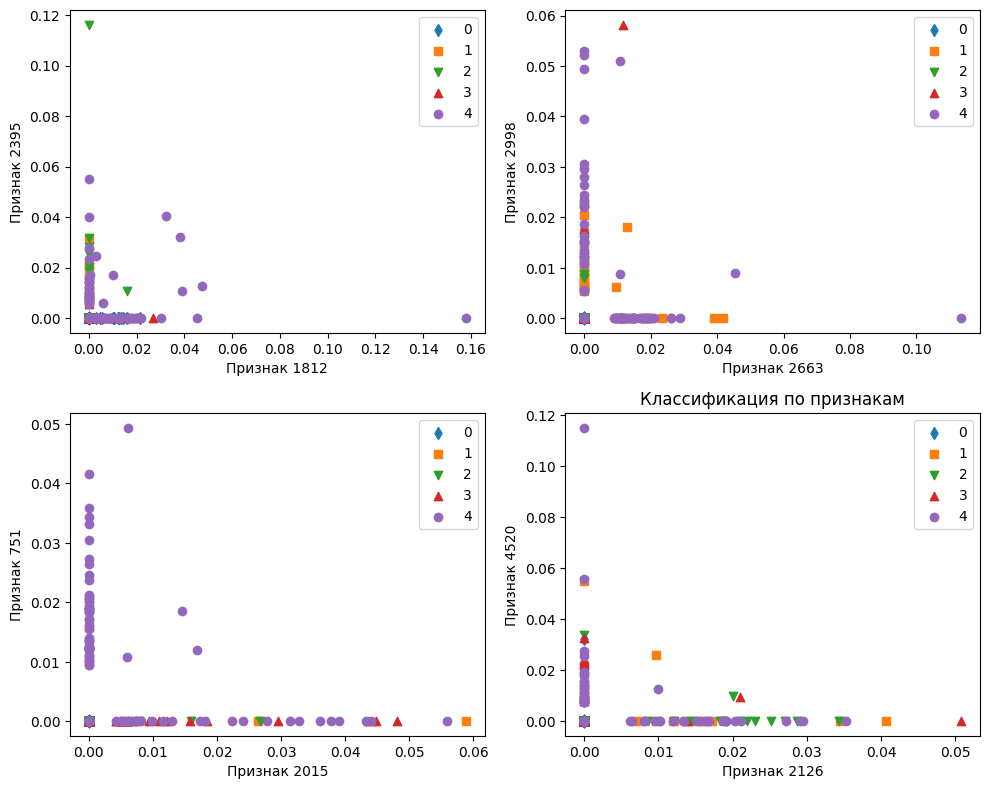

In [115]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

MARKERS = ['d', 's', 'v', '^', 'o']

# Берём пользователей, слушающих больше всего разных исполнителей, они будут показательнее всего
params = ratings.apply(lambda s: (s != 0).sum()).sort_values(ascending=False).head(8).index

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs: np.ndarray
for v in range(5):
    relevant = ratings[kmeans_normal_labels == v]
    for i, ax in zip(range(4), axs.flatten()):
        ax: Axes
        param_x = params[2*i]
        param_y = params[2*i+1]
        ax.scatter(relevant[param_x], relevant[param_y], marker=MARKERS[v], label=v)
        ax.legend()
        ax.set_xlabel(f"Признак {param_x}")
        ax.set_ylabel(f"Признак {param_y}")
plt.title("Классификация по признакам")
plt.tight_layout()
plt.show()

**Ответ:**
> Не очень информативно. Каждый слушает лишь малюсенькую долю исполнителей в выборке, поэтому большинство улетают в (0; 0) или, если повезёт, на одну из осей — в пространство *x > 0, y > 0* попадают единицы

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

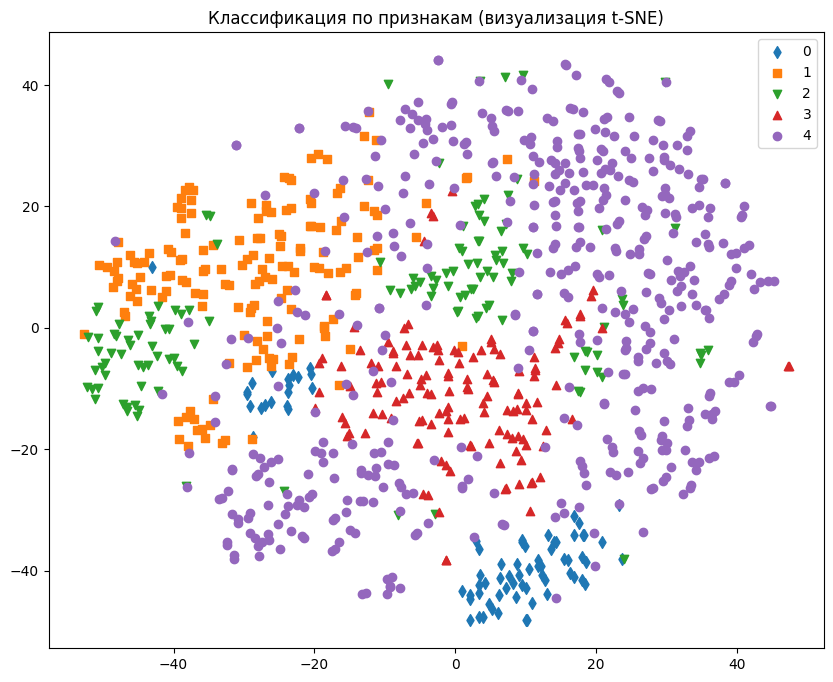

In [117]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=239)
ratings_normal_tsne = tsne.fit_transform(ratings_normal)

plt.figure(figsize=(10, 8))
for v in range(5):
    relevant = ratings_normal_tsne[kmeans_normal_labels == v]
    plt.scatter(*relevant.T, marker=MARKERS[v], label=v)
plt.legend()
plt.title("Классификация по признакам (визуализация t-SNE)")
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

# -- YOUR CODE HERE --

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Сделайте t-SNE визуализацию полученной кластеризации.

In [ ]:
# -- YOUR CODE HERE --

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --